In [1]:
!pip install py-bangla-stemmer
!pip install git+https://github.com/banglakit/bengali-stemmer.git
!wget https://raw.githubusercontent.com/RafiKamal/bengali-stemmer/master/rafikamal2014/common.rules -O /usr/local/lib/python3.10/dist-packages/bengali_stemmer/rafikamal2014/common.rules

  Preparing metadata (setup.py) ... done
  Created wheel for py-bangla-stemmer: filename=py_bangla_stemmer-0.5.1-py3-none-any.whl size=17335 sha256=2a7eeeb13e48c9b6bd5b1e410c4fd40b3ac215e286ae520144c3968c5dbd314d
  Stored in directory: /root/.cache/pip/wheels/28/08/e3/e6c9711a05c5d7024df26af24bf2cfd5bc529c48ba8c8b872a
Successfully built py-bangla-stemmer
  Cloning https://github.com/banglakit/bengali-stemmer.git to /tmp/pip-req-build-9br_7v91
  Running command git clone --filter=blob:none --quiet https://github.com/banglakit/bengali-stemmer.git /tmp/pip-req-build-9br_7v91
  Resolved https://github.com/banglakit/bengali-stemmer.git to commit 6640fadc499b249e0532a9ff7889fb2146901e71
  Preparing metadata (setup.py) ... done
  Created wheel for bengali-stemmer: filename=bengali_stemmer-0.0.1-py2.py3-none-any.whl size=6389 sha256=87abb2095653f73ce947b393e289829da2946d3dba559c7c9b24a80aef0c1aa5
  Stored in directory: /tmp/pip-ephem-wheel-cache-bxfpz6e7/wheels/ab/46/9c/9ecafb051bc92c8ab0982db

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'
import logging
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, matthews_corrcoef
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import string
import seaborn as sns
sns.set_style("whitegrid")

# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
# Text Classifiation using NLP
import pickle
nltk.download('punkt')
import numpy as np
import pandas as pd
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/kaggle/input/sentiment-analysis/Sentiment_Analysis.csv


In [3]:
RAW_DATA = pd.read_csv("/kaggle/input/sentiment-analysis/Sentiment_Analysis.csv",encoding="UTF-8")
RAW_DATA = RAW_DATA.sample(frac=1, random_state=100).reset_index(drop=True)
RAW_DATA.head(10)

,RawText,Label
0,শেষ পর্যন্ত ওভার ডোজ হয়ে গেলে আমার মারা যাওয়...,Suicidal Thought
1,আমার আত্মহত্যার চিন্তাভাবনা রয়েছে এবং আমি নিজ...,Suicidal Thought
2,ভালোবাসা সুন্দর যদি সঠিক মানুষ পায়,Depressive Thought
3,আমি ক্লান্ত। এখনই। নার্সিসিস্ট পুত্রবধূর কারণে...,Suicidal Thought
4,ফুল ফুটুক আর না ফুটুক আজ বসন্ত। সবাইকে বসন্তে...,Non Depressive Thought
5,"নেককাজ কণ্টকাকীর্ণ, প্রতি কদমেই কষ্ট বাড়বে, কি...",Non Depressive Thought
6,আমি আমার বাবার সাথে থাকি এবং সে আমাকে ভালবাসে ...,Suicidal Thought
7,আমি এত লড়াই করছি যে আমি আমার বাড়ি ছেড়ে যেতে...,Suicidal Thought
8,কোন এক সময় চিরবিদায় নিয়ে চলে যাবো দুনিয়া থেকে।।,Depressive Thought
9,মানবতার এক অনন্য দৃষ্টান্ত রাখলো আমার ভার্সিটি!,Non Depressive Thought


In [4]:
# Assuming RAW_DATA is your original DataFrame
main_cols = ['RawText', 'Label']
data = RAW_DATA[main_cols]

# Shuffle the data
data = data.sample(frac=1, random_state=0).reset_index(drop=True)

# Drop null values
data = data.dropna()
# Remove duplicates
data = data.drop_duplicates()

# Reset index after dropping null values
data = data.reset_index(drop=True)
data.head()

,RawText,Label
0,গজব পড়বে।,Depressive Thought
1,আমি প্রায় প্রতিদিনই অত্যন্ত রেগে যাই এবং স্টি...,Suicidal Thought
2,"3 বছর আগে একবার আমার বিষণ্নতা ছিল, যে কারণে আম...",Suicidal Thought
3,সুবর্নভুমি রিসোর্ট ট্যুরের কিছু আনন্দময় মুহূর্ত।,Non Depressive Thought
4,"বন্ধুরা, আমি আমার পরিবারের বিরুদ্ধে, আইনশৃঙ্খল...",Suicidal Thought


In [5]:
data.describe()

,RawText,Label
count,6152,6152
unique,6150,3
top,বলার অধিকার দিতে হবে সকলকে।,Suicidal Thought
freq,2,2305


In [6]:
data.isnull().sum()
data.shape

(6152, 2)

In [7]:
from py_bangla_stemmer import BanglaStemmer
from bengali_stemmer.rafikamal2014 import RafiStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
# Initialize Bengali stemmer
stemmer = RafiStemmer()

def clean_text(text):
    if isinstance(text, float):  # Check if text is NaN
        return ""  # Return empty string for NaN values
    # HTML decoding
    text = BeautifulSoup(text, "html.parser").text
    # Lowercase text
    text = text.lower()
    # Replace specific symbols with space
    text = re.sub('[/(){}\[\]\|@,;!“ ”?#+-_*"%]', ' ', text)
    # Remove decimal numbers
    text = re.sub("\d+\.?\d*", " ", text)
    # Remove English alphabets
    text = re.sub('[a-zA-Z]', ' ', text)
    # Remove specific Bengali symbols
    text = re.sub('[।.]', ' ', text)
    # Remove single quotes
    text = text.replace("'", "")

    # Tokenize text into words and apply Bengali stemming
    tokenized_words = word_tokenize(text)
    stemmed_words = [stemmer.stem_word(word) for word in tokenized_words]

    # Join stemmed words back into a cleaned text
    cleaned_text = ' '.join(stemmed_words)
    
    return cleaned_text

data['RawText'] = data['RawText'].apply(clean_text)

In [8]:
data['Label'].value_counts()

Label
Suicidal Thought          2305
Depressive Thought        1960
Non Depressive Thought    1887
Name: count, dtype: int64

In [9]:
data['Label'] = data['Label'].map({'Non Depressive Thought': 0, 'Depressive Thought': 1, 'Suicidal Thought':2})

In [10]:
data['Label'].value_counts()

Label
2    2305
1    1960
0    1887
Name: count, dtype: int64

In [11]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(data['RawText']).reshape(-1, 1), np.array(data['Label']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['RawText', 'Label']);

In [12]:
train_os['Label'].value_counts()

Label
1    2305
2    2305
0    2305
Name: count, dtype: int64

In [13]:
X = train_os['RawText'].values
y = train_os['Label'].values

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [15]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
# y_test_le = y_test.copy()

In [16]:
from sklearn import preprocessing

ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
# y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [17]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}" )

TRAINING DATA: 4840
VALIDATION DATA: 2075


In [18]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_valid_cv = clf.transform(X_valid)

In [19]:
from sklearn.feature_extraction.text import TfidfTransformer

tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_valid_tf = tf_transformer.transform(X_valid_cv)

> # ***RoBERTa-SAN Sentiment Analysis***

In [20]:
MAX_LEN=256

In [21]:
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

2024-05-20 13:02:19.540452: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 13:02:19.540554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 13:02:19.672870: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [22]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [23]:
# Loading RoBERTa model
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [24]:
def tokenize_roberta(data, tokenizer_roberta, max_len=MAX_LEN):
    input_ids = []
    attention_masks = []
    for text in data:
        encoded = tokenizer_roberta.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
#         print("Input IDs shape:", np.array(input_ids).shape)
#         print("Attention masks shape:", np.array(attention_masks).shape)
    return np.array(input_ids), np.array(attention_masks)

In [25]:
train_input_ids, train_attention_masks = tokenize_roberta(X_train, tokenizer_roberta, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(X_valid, tokenizer_roberta, MAX_LEN)

In [26]:
val_input_ids

array([[    0, 35861, 11582, ...,     1,     1,     1],
       [    0, 35861,  2840, ...,     1,     1,     1],
       [    0, 35861,  4958, ...,     1,     1,     1],
       ...,
       [    0, 35861,  9357, ...,     1,     1,     1],
       [    0, 35861, 18537, ...,  1437, 35861,     2],
       [    0, 35861, 19002, ...,     1,     1,     1]])

In [27]:
import tensorflow as tf

class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, use_masking=True):
        super(SelfAttention, self).__init__()
        self.num_heads = num_heads
        self.use_masking = use_masking

    def build(self, input_shape):
        self.d_model = input_shape[-1]
        assert self.d_model % self.num_heads == 0

        self.depth = self.d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=self.d_model)
        self.key_dense = tf.keras.layers.Dense(units=self.d_model)
        self.value_dense = tf.keras.layers.Dense(units=self.d_model)

        self.dense = tf.keras.layers.Dense(units=self.d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]

        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention_logits = tf.matmul(
            query, key, transpose_b=True) / tf.math.sqrt(tf.cast(self.depth, tf.float32))

        if self.use_masking:
            mask = tf.linalg.band_part(tf.ones((input_shape[1], input_shape[1])), -1, 0)
            mask = 1 - mask  # Invert 1s and 0s
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

        output = tf.matmul(attention_weights, value)
        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))

        output = self.dense(output)

        return output

In [28]:
import tensorflow as tf

def create_model2(roberta_model, max_len=MAX_LEN):
    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')

    # RoBERTa model as a layer
    roberta_output = roberta_model([input_ids, attention_masks])

    # Last hidden state from RoBERTa
    bert_output_cls = roberta_output[0][:, 0, :]  # Use only the [CLS] token representation

    # Self-Attention Network layer
    san_output = SelfAttention(num_heads=8, use_masking=True)(roberta_output[0])
#     print("Shape of san_output:", san_output.shape)

    # Global Average Pooling
    san_output_pooled = tf.keras.layers.GlobalAveragePooling1D()(san_output)
#     print("Shape of bert_output_cls:", bert_output_cls.shape)
#     print("Shape of san_output_pooled:", san_output_pooled.shape)

    # Concatenate RoBERTa output with SAN output
    combined_output = tf.keras.layers.concatenate([bert_output_cls, san_output_pooled])

    # Output layer for classification
    output = tf.keras.layers.Dense(3, activation='softmax')(combined_output)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    model.compile(optimizer=opt, loss=loss, metrics=[accuracy])

    return model

In [29]:
model2 = create_model2(roberta_model, MAX_LEN)
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_1[0][0]',             
 aModel)                     ngAndCrossAttentions(last_   32         'input_2[0][0]']             
                             hidden_state=(None, 256, 7                                           
                             68),                                                             

In [30]:
history_robertasan = model2.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=30, batch_size=32)

Epoch 1/30


I0000 00:00:1716210265.130867     155 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


152/152 [==============================] - 290s 1s/step - loss: 0.6917 - categorical_accuracy: 0.6118 - val_loss: 0.6047 - val_categorical_accuracy: 0.6482
Epoch 2/30
152/152 [==============================] - 182s 1s/step - loss: 0.5892 - categorical_accuracy: 0.6638 - val_loss: 0.5759 - val_categorical_accuracy: 0.6713
Epoch 3/30
152/152 [==============================] - 182s 1s/step - loss: 0.5541 - categorical_accuracy: 0.6909 - val_loss: 0.5686 - val_categorical_accuracy: 0.7002
Epoch 4/30
152/152 [==============================] - 182s 1s/step - loss: 0.5361 - categorical_accuracy: 0.7035 - val_loss: 0.5418 - val_categorical_accuracy: 0.7186
Epoch 5/30
152/152 [==============================] - 182s 1s/step - loss: 0.5031 - categorical_accuracy: 0.7368 - val_loss: 0.5888 - val_categorical_accuracy: 0.6882
Epoch 6/30
152/152 [==============================] - 181s 1s/step - loss: 0.4820 - categorical_accuracy: 0.7500 - val_loss: 0.5644 - val_categorical_accuracy: 0.7147
Epoch 7/3

In [31]:
result_roberta_san = model2.predict([val_input_ids,val_attention_masks])
y_pred_roberta_san =  np.zeros_like(result_roberta_san)
y_pred_roberta_san[np.arange(len(y_pred_roberta_san)), result_roberta_san.argmax(1)] = 1

65/65 [==============================] - 36s 342ms/step


In [32]:
print('Classification Report for RoBERTaSAN:\n\n',classification_report(y_valid, y_pred_roberta_san, target_names=['Non Depressive Thought', 'Depressive Thought', 'Suicidal Thought']))

Classification Report for RoBERTaSAN:

                         precision    recall  f1-score   support

Non Depressive Thought       0.74      0.72      0.73       691
    Depressive Thought       0.72      0.72      0.72       692
      Suicidal Thought       0.92      0.96      0.94       692

             micro avg       0.80      0.80      0.80      2075
             macro avg       0.79      0.80      0.80      2075
          weighted avg       0.79      0.80      0.80      2075
           samples avg       0.80      0.80      0.80      2075



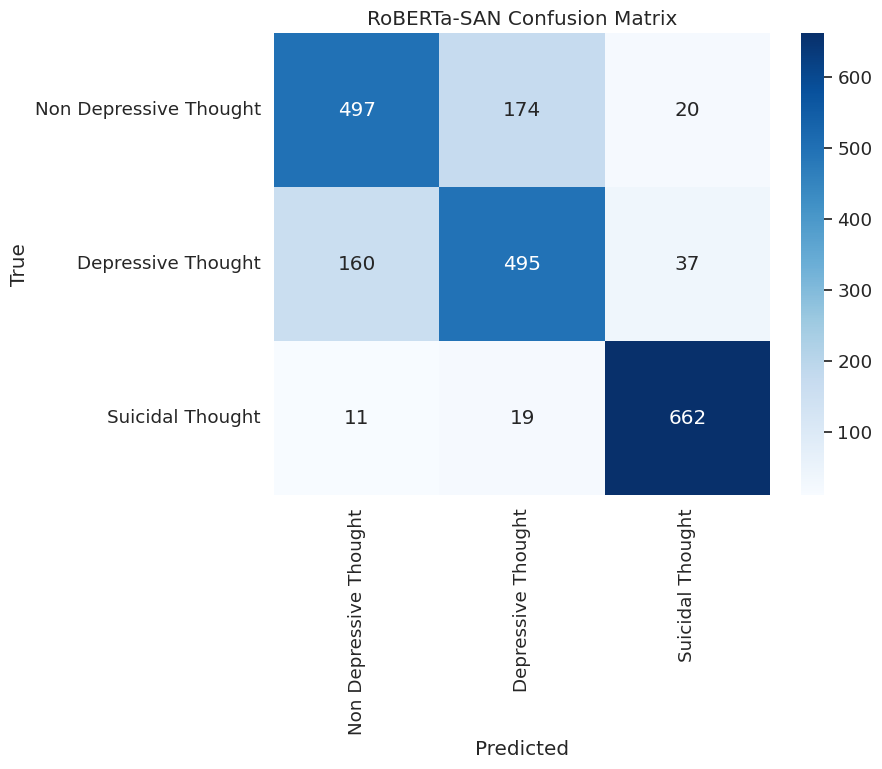

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_valid.argmax(1), y_pred_roberta_san.argmax(1))

class_names = ['Non Depressive Thought', 'Depressive Thought', 'Suicidal Thought']

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better readability
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('RoBERTa-SAN Confusion Matrix')
plt.show()